In [66]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split, KFold
import matplotlib.pyplot as plt
from tabulate import tabulate
import math
from scipy.stats import boxcox
import seaborn as sns
import gmplot
from sklearn.metrics import classification_report, confusion_matrix, r2_score, mean_absolute_error

In [2]:
#read in the target data
solar_data = pd.read_csv('Solar Data/project-sunroof-postal_code-09082017.csv')
solar_data.drop(0, inplace = True)
#convert the column containing postal codes from str to int
solar_data['region_name'] = solar_data['region_name'].apply(lambda x : int(x))

In [3]:
#read in the median home value data
homevalue = pd.read_csv('Solar Data/Zip_Zhvi_Summary_AllHomes.csv')
homevalue = homevalue[['RegionName', 'Zhvi']]

In [4]:
#read in census data
census = pd.read_csv('scraped_from_census.csv')
census = census[['zipcode', 'population','medianage', 'medianincome','pctownocc']]
#merge target data with census data
census_solar = solar_data[['region_name','existing_installs_count']].merge(census, left_on = 'region_name', right_on = 'zipcode', how = 'inner')
#merge in home value data with other data
census_solar_home = census_solar.merge(homevalue, left_on = 'zipcode', right_on = 'RegionName', how = 'inner')
#read in solar radiation data
solar_rad = pd.read_csv('Solar_Radiation_by_zip.csv')
#drop the rows where the solar data was not available
solar_rad = solar_rad[solar_rad.solar_radiation !=  'error']
#merge solar radiation data in to the rest of the data
census_solar_home_rad = census_solar_home.merge(solar_rad,on = 'zipcode', how = 'inner')

In [5]:
#trim the unneeded columns from the data
census_solar_home_rad= census_solar_home_rad[['zipcode',  'population',
       'medianage', 'medianincome', 'pctownocc', 'Zhvi',
       'solar_radiation','existing_installs_count']]
#convert solarion radiation data from str to float
census_solar_home_rad['solar_radiation'] = census_solar_home_rad['solar_radiation'] .apply(lambda x : float(x))
#rename all the combined data as data
data = census_solar_home_rad

First we need to establish a target feature.  We'll call that per_capita and calculate it as number of installs for every 100 people in a given geographic area (zip code)

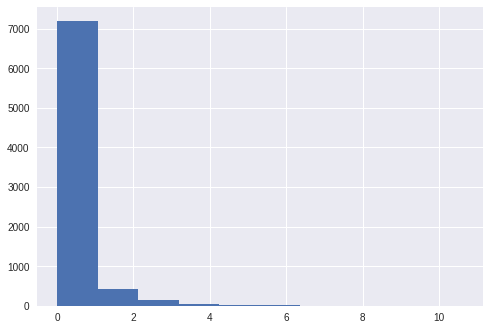

In [6]:
#generate a target feature.  Our target is the number of installs per 100 people
data['per_capita'] = (data['existing_installs_count']/data['population']*100)
#plot the target variable to get a sense as to what we are working with
plt.hist(data['per_capita'])
plt.show()

This initial data is heavily skewed towards zero.  So let's take a look at how we might be able to transform this data to make it easier for a model to get some footing.

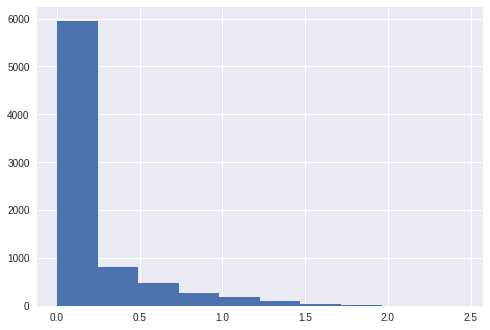

In [7]:
#try a log transformation on the variable to see if we can spread it out a little better
test = data['per_capita'].apply(lambda x: math.log(x+1))
plt.hist(test)
plt.show()

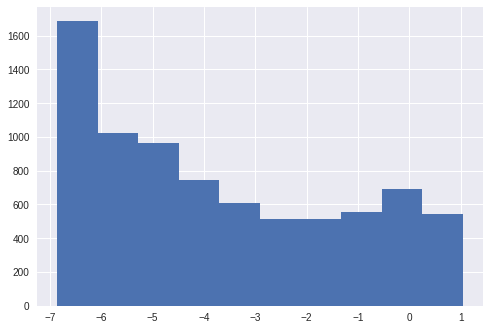

In [8]:
#try a boxcox transformation on the target to see if we can normalize it a bit
test = boxcox(data.per_capita.apply(lambda x: x+0.1))[0]
plt.hist(test)
plt.show()

In [9]:
#the boxcox transformation was good so overwrite the feature as the transformed boxcox data
data.per_capita = test

A box cox transformation on the target normalized the distribution quite well.  Lets see what we can do to the other variables. Zhvi (median home value) should be a strong feature.  Let's take a look at the distribution and see how me might play with that data. 

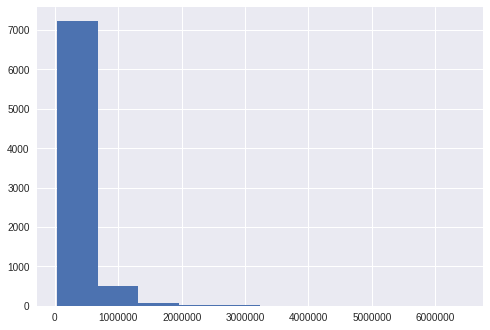

In [10]:
#plot home median home value data.  We have a similar issue here as we did with the target feature
plt.hist(data.Zhvi)
plt.show()

Well, there are some pretty extreme datapoints that I think we will want to eliminate so let's do that and then try some transformations

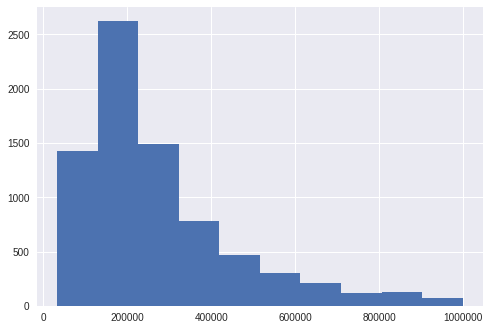

In [11]:
#lets drop the very overpriced homes, looks much better now, distribution has some spread to it.
data = data[data.Zhvi <= 1000000]
plt.hist(data.Zhvi)
plt.show()

Thats some pretty fair ditribution on Zhvi and we got the correlation between our target and the feature up to 0.48.  Let's see if we can do that with some other features.  Let's look at sunlight next.

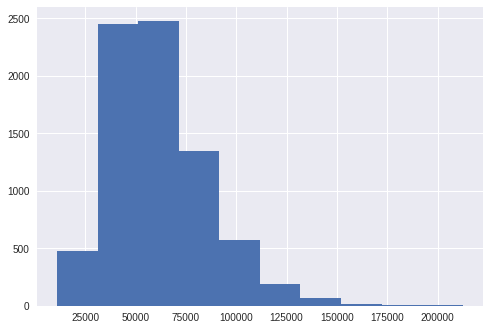

In [12]:
#median income also seems to have some outliers
plt.hist(data['medianincome'])
plt.show()

In [13]:
#drop those outliers for median income
data = data[data['medianincome'] < 150000]

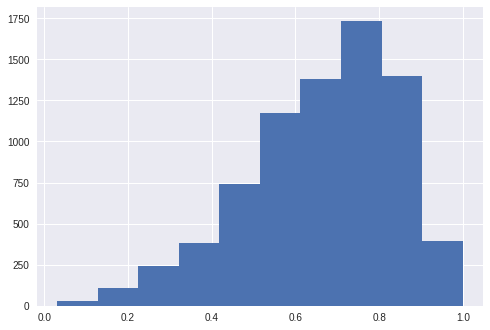

In [14]:
#the percent of homes occupied by the owner looks like a healthy distribution, we can leave it alone.
plt.hist(data['pctownocc'])
plt.show()

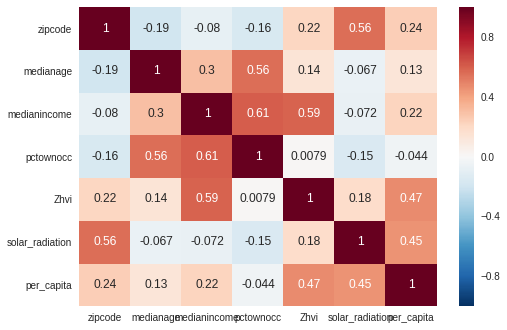

In [15]:
#plot a correlation map just to see how data are related
corr = data.drop(['existing_installs_count','population'], axis = 1).corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot= True)
plt.show()

In [16]:
#drop Nan for good measure
data.dropna(inplace = True)
#set features to X
X = data.drop(['existing_installs_count','population','per_capita', 'zipcode'], axis = 1)
#and target to Y
Y = data['per_capita']

In [65]:
#train and test split on the data
X_train, X_test,Y_train, Y_test = train_test_split(X, Y, train_size = 0.8)
rfr = RandomForestRegressor()

rfr.fit(X_train, Y_train)
Y_ = rfr.predict(X_test)
print('MAE: {}'.format(mean_absolute_error(Y_test, Y_)))

MAE: 0.8278144239226043


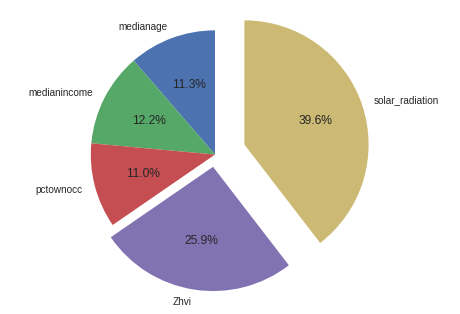

In [18]:
#set lables from features
labels = X_train.columns
#retrieve relative importance of features from random forests
sizes = rfr.feature_importances_
#set explode parameters to make the chart look nice
explode = (0, 0,0  ,.1, .25)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax1.axis('equal')

plt.show()

In [19]:
score = cross_val_score(rfr, X, Y, cv=5)
print(score.mean())
print(score.std())
score

-0.188999883355
0.187755486372


array([-0.31630568,  0.07125042, -0.45407578, -0.04129767, -0.20457071])

In [20]:
gbr = GradientBoostingRegressor()
score = cross_val_score(gbr, X, Y, cv=5)
print(score.mean())
print(score.std())
score

-0.0853115617833
0.147422315171


array([-0.23187393,  0.17481081, -0.11451637, -0.04056476, -0.21441355])

In [22]:
#set lower 1/3 bound value for setting up the target as a classification problem with 3 classes
low3 = data.per_capita.median() - data.per_capita.std()/2
#set higher 1/3 bound value for setting up the target as a classification problem with 3 classes
high3 = data.per_capita.median() + data.per_capita.std()/2
#set median for use of classification with only 2 classes
median = data.per_capita.median()

In [23]:
#define classes for classification model 0 for low, 1 for medium and 2 for high end.
data['class'] = data['per_capita'].apply(lambda x: 0 if x <= low3 else (2 if x >= high3 else 1))

In [24]:
#data['class'] = data['per_capita'].apply(lambda x: 0 if x <= median else 1)

In [25]:

rfc = RandomForestClassifier()

In [26]:
#define features for classifcation model
X = data.drop(['existing_installs_count','population','per_capita', 'zipcode', 'class'], axis = 1)
#define target for classification model
Y = data['class']

In [27]:
score = cross_val_score(rfc, X, Y, cv=5)
print(score.mean())
print(score.std())
score

0.453360381132
0.0397926409448


array([ 0.37903757,  0.46701847,  0.49538259,  0.47424042,  0.45112285])

In [28]:
#train test split
X_train, X_test,Y_train, Y_test = train_test_split(X, Y, train_size = 0.8)

rfc.fit(X_train, Y_train)
Y_ = rfc.predict(X_test)
print('r2 : {}'.format(r2_score(Y_test, Y_)))
print('MAE: {}'.format(mean_absolute_error(Y_test, Y_)))

r2 : 0.04998259624028689
MAE: 0.5098944591029023


In [29]:
confusion_matrix(Y_test,Y_)

array([[276, 157,  48],
       [170, 191,  95],
       [ 66, 123, 390]])

In [30]:
print(classification_report(Y_test,Y_))

             precision    recall  f1-score   support

          0       0.54      0.57      0.56       481
          1       0.41      0.42      0.41       456
          2       0.73      0.67      0.70       579

avg / total       0.57      0.57      0.57      1516



In [53]:
#reread in my raw data to make predictions on other data
homevalue = pd.read_csv('Solar Data/Zip_Zhvi_Summary_AllHomes.csv')
homevalue = homevalue[['RegionName', 'Zhvi']]
test = pd.read_csv('scraped_from_census.csv')
test= test[['zipcode', 'population','medianage', 'medianincome','pctownocc']]
test_solar_home = test.merge(homevalue, left_on = 'zipcode', right_on = 'RegionName', how = 'inner')
solar_rad = pd.read_csv('Solar_Radiation_by_zip.csv')
solar_rad = solar_rad[solar_rad.solar_radiation !=  'error']
data_to_predict = test_solar_home.merge(solar_rad,on = 'zipcode', how = 'inner')


In [54]:
#drop zip codes that were used in the model generation
data_to_predict = data_to_predict[~data_to_predict.zipcode.isin(data.zipcode)]
X_ = data_to_predict.drop(['population','RegionName', 'zipcode'], axis = 1)

In [55]:
#save the predicted values
Y_ = rfc.predict(X_)
#save the predicted values the featureset
data_to_predict['class'] = Y_

In [57]:
#load all latitude and longitudes for zip codes
zip_lats_longs = pd.read_csv('us_postal_codes.csv')
#drop the unnessesary parts of the data
zip_lats_longs = zip_lats_longs[['Zip Code', 'Latitude','Longitude']]
#merge the lats and longs onto the data with the predicted values
to_plot = data_to_predict.merge(zip_lats_longs, left_on = 'zipcode', right_on = 'Zip Code', how = 'inner')

In [60]:
#break up the data into 3 datasets, good, medium and bad predicted markets
good_markets = to_plot[to_plot['class'] == 2]
medium_markets = to_plot[to_plot['class'] == 1]
bad_markets = to_plot[to_plot['class'] == 0]
#center and zoom the map over the united states
gmap = gmplot.GoogleMapPlotter(to_plot['Latitude'].mean(), to_plot['Longitude'].mean(), 4)
#plot some black dots to back the green dots for contrast
gmap.scatter(good_markets['Latitude'], good_markets['Longitude'], '#000000', size=5000, marker=False)
#plot green dots to represent good markets
gmap.scatter(good_markets['Latitude'], good_markets['Longitude'], '#00ff00', size=4000, marker=False)
#plot yellow dots to represent medium markets
gmap.scatter(medium_markets['Latitude'], medium_markets['Longitude'], '#ffff00', size=4000, marker=False)
#plot red dots to represent bad markets
gmap.scatter(bad_markets['Latitude'], bad_markets['Longitude'], '#ff0000', size=4000, marker=False)
#draw the mapfile
gmap.draw('marketpredictions.html')

In [61]:
X = X.reset_index()
Y = Y.reset_index()

In [62]:
def crossvalidate(estimator, data, target, folds):
    scores = []
    k_fold = KFold(folds)
    for k, (train, test) in enumerate(k_fold.split(data)):
        estimator.fit(data[train], target[train])
        print("[fold {0}] score: {2:.5f}".
         format(k, estimator.score(data[test],target[test])))

In [63]:
crossvalidate(rfr, X, Y, 5)

KeyError: '[1516 1517 1518 ..., 7574 7575 7576] not in index'